In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

# Demography

## Natality/birth rates

We import from the data of the Eurostat regarding the 2008-2015 data on fertility rates.
These is the ratio between the number of births of females of a given age over the population of females of that age.
Data are given in NUTS2 level.

In [3]:
fileName = "resources/Europe/population/demography/birthRates_1990-2015_age_nuts2_PANDAS.tsv"
birth_df = pd.read_csv(fileName, sep="\t")
birth_df["codes"] = birth_df[birth_df.columns[0]]
del birth_df[birth_df.columns[0]]
birth_df["age"] = birth_df["codes"].apply(lambda v: v.split(",")[1])
birth_df["nuts"] = birth_df["codes"].apply(lambda v: v.split(",")[2])
del birth_df["codes"]

birth_df = birth_df.rename({k: int(k) if k not in ["age", "nuts"] else k for k in birth_df.columns}, axis="columns")

birth_df.replace(to_replace=": ", value=0, inplace=True)
birth_df = birth_df[birth_df.age != "TOTAL"]

for c in birth_df.columns[:-2]:
    birth_df[c] = birth_df[c].astype(float)
    
birth_df.age = birth_df.age.apply(lambda v: v.split("Y")[1])

birth_df.head()

,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,...,1997,1996,1995,1994,1993,1992,1991,1990,age,nuts
473,0.00015,0.00019,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10-14,AL
474,0.00015,0.00017,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10-14,AL0
475,0.00007,0.00007,0.00005,0.00003,0.00005,0.00008,0.00006,0.00003,0.00003,0.00008,...,0.00006,0.00005,0.00008,0.00009,0.00007,0.00009,0.00011,0.00009,10-14,AT
476,0.00010,0.00012,0.00008,0.00002,0.00006,0.00016,0.00011,0.00005,0.00003,0.00012,...,0.00011,0.00009,0.00017,0.00000,0.00000,0.00000,0.00000,0.00000,10-14,AT1
477,0.00015,0.00000,0.00015,0.00000,0.00000,0.00015,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00012,0.00000,0.00000,0.00000,0.00000,0.00000,10-14,AT11


We assume:
- no children before 12 years old (we copy the 10-14 value to 12, 13 and 14 years);
- no children after 55 years old (we copy the GE50 value to 50, 51, 52, 53, 54, 55 years);

In [4]:
birth_df.age.unique()

array(['10-14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '_GE50'], dtype=object)

In [5]:
%%time
todoNuts = sorted(birth_df["nuts"].unique())
# Copy the teen and older rows and fill the dataframe.
# If the row is missing we use the last one (hopefully close nuts
# share similar stats and hopefullly we won't miss the first one)

agesYoung, agesOld = list(range(12, 15)), list(range(50, 56))
NagesYoung, NagesOld = len(agesYoung), len(agesOld)
agesToCopy = agesYoung + agesOld
agesPerNuts = len(agesToCopy)

dataToAppend = np.zeros(shape=(agesPerNuts*len(todoNuts), birth_df.shape[1]-2), dtype=float)
copied = 0
for nuts in todoNuts:
    tmp_rowTeen = birth_df[(birth_df.nuts == nuts) & (birth_df.age == "10-14")].copy()
    if tmp_rowTeen.shape[0] > 0:
        last_teen = tmp_rowTeen
    else:
        tmp_rowTeen = last_teen
        tmp_rowTeen.nuts = nuts
        print "missing young ", nuts
    dataToAppend[copied:copied+NagesOld, :] = tmp_rowTeen.values[0][:-2]
    copied += NagesYoung
    
    tmp_rowOld = birth_df[(birth_df.nuts == nuts) & (birth_df.age == "_GE50")].copy()
    if tmp_rowOld.shape[0] > 0:
        last_old = tmp_rowOld
    else:
        tmp_rowOld = last_old
        tmp_rowOld.nuts = nuts
        print "missing old ", nuts
    dataToAppend[copied:copied+NagesOld, :] = tmp_rowOld.values[0][:-2]
    copied += NagesOld
    
dataToAppend = [list(d) + code for d, code in zip(dataToAppend, [[age, nuts] for nuts in todoNuts for age in agesToCopy])]
dataToAppend = pd.DataFrame(dataToAppend, columns=birth_df.columns)
birth_df = birth_df.append(dataToAppend, ignore_index=True, verify_integrity=True)

birth_df = birth_df[ ~(birth_df.age.isin(["_GE50", "10-14"])) ]
birth_df.age = birth_df.age.astype(int)

missing young  UKI3
missing old  UKI3
missing young  UKI4
missing old  UKI4
missing young  UKI5
missing old  UKI5
missing young  UKI6
missing old  UKI6
missing young  UKI7
missing old  UKI7
CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 2.66 s


In [6]:
%%time
# Insert for each lad the 1-11 and 56-100 ages with zero values
todoAges = list(range(1, 12)) + list(range(56, 101))

dataToAppend = pd.DataFrame([[.0 for i in range(birth_df.shape[1]-2)] + [age, nuts] for nuts in todoNuts for age in todoAges],
                            columns=birth_df.columns)
birth_df = birth_df.append(dataToAppend, ignore_index=True, verify_integrity=True)

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 127 ms


In [7]:
birth_df.age.unique()

array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  12,  13,  14,  50,
        51,  52,  53,  54,  55,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [8]:
birth_df.tail()

,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,...,1997,1996,1995,1994,1993,1992,1991,1990,age,nuts
47285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96,UKN0
47286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97,UKN0
47287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,UKN0
47288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99,UKN0
47289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100,UKN0


In [9]:
# So long for the ladies, now we copy the dataframe for the boys and set the natality to zero always.
boys = birth_df.copy(deep=True)
girls = birth_df

for c in boys.columns[:-2]:
    boys[c] = .0

boys["sex"] = 0
girls["sex"] = 1

In [10]:
birth_df = pd.concat([boys, girls], ignore_index=True, verify_integrity=True)
birth_df = birth_df.pivot_table(columns=["sex", "age"], index=["nuts"], fill_value=0.)
birth_df.head()

1990                                     ... 2015                      \
sex     0                                     ...    1                       
age   1   2   3   4   5   6   7   8   9   10  ...  91  92  93  94  95  96    
nuts                                          ...                            
AL      0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AL0     0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT      0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT1     0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT11    0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   

                      
sex                   
age  97  98  99  100  
nuts                  
AL     0   0   0   0  
AL0    0   0   0   0  
AT     0   0   0   0  
AT1    0   0   0   0  
AT11   0   0   0   0  

[5 rows x 5200 columns]

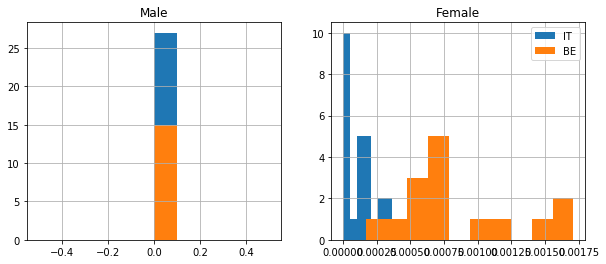

In [11]:
year = 2015
age = 15
sexes = {1: "Female", 0: "Male"}
countries = ["IT", "BE"]

nSexes = len(sexes)
plt.figure(figsize=(5*nSexes,4))
for i, sex in enumerate(sexes):
    plt.subplot(1,nSexes,1+i)
    plt.title(sexes[sex])
    for country in countries:
        birth_df[year, sex, age][birth_df.index.str.startswith(country)].hist(label=country)
plt.legend()

In [12]:
# Save table for later use...
birth_df.to_pickle("resources/Europe/population/demography/birthRates_1990-2015_age_nuts2_PANDAS.pkl")

## Mortality/death rates

We import from the data of the Eurostat regarding the 2008-2015 data on mortality probability for age and sex.

These is the probability for a person of a given sex and age to die before the next birthday.
Data are given in NUTS2 level.

In [13]:
fileName = "resources/Europe/population/demography/deathRates_1990-2015_sexAge_nuts2_PANDAS.tsv"
death_df = pd.read_csv(fileName, sep="\t")
death_df["codes"] = death_df[death_df.columns[0]]
del death_df[death_df.columns[0]]
death_df["indicator"] = death_df["codes"].apply(lambda v: v.split(",")[0])
death_df["sex"]  = death_df["codes"].apply(lambda v: v.split(",")[1])
death_df["age"]  = death_df["codes"].apply(lambda v: v.split(",")[2])
death_df["nuts"] = death_df["codes"].apply(lambda v: v.split(",")[3])
del death_df["codes"]

death_df = death_df.rename({k: int(k) if k not in ["age", "nuts", "sex", "indicator"] else k for k in death_df.columns}, axis="columns")

death_df.replace(to_replace=": ", value=0, inplace=True)
death_df = death_df[death_df.age != "TOTAL"]
death_df = death_df[death_df.indicator == "PROBDEATH"]
del death_df["indicator"]

for c in death_df.columns[:-3]:
    death_df[c] = death_df[c].astype(float)
    
death_df.age = death_df.age.apply(lambda v: v.split("Y")[1])

death_df.head()

,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,...,1996,1995,1994,1993,1992,1991,1990,sex,age,nuts
366102,0.00043,0.00043,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,F,1,AL
366103,0.00043,0.00042,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,F,1,AL0
366104,0.00017,0.00015,0.00016,0.00018,0.00018,0.00034,0.00042,0.00039,0.00036,0.00036,...,0.00034,0.00035,0.00050,0.00065,0.00057,0.00052,0.00067,F,1,AT
366105,0.00023,0.00023,0.00024,0.00018,0.00018,0.00030,0.00043,0.00042,0.00054,0.00030,...,0.00023,0.00000,0.00072,0.00066,0.00061,0.00041,0.00065,F,1,AT1
366106,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00090,0.00000,0.00088,...,0.00000,0.00000,0.00072,0.00000,0.00071,0.00000,0.00000,F,1,AT11


We make these assumptions:
- the death rate at zero years is ignored (agents are born as if they have one year);
- we set the values for age $85 \le y \le 100$ to the values of `_GE85`.

In [14]:
#%%time
todoNuts = sorted(death_df["nuts"].unique())
# Copy the 85+ rows and fill the dataframe.
# If the row is missing we use the last one (hopefully close nuts
# share similar stats and hopefullly we won't miss the first one)

agesOld = list(range(85, 101))
NagesOld = len(agesOld)
agesToCopy = agesOld
agesPerNuts = len(agesToCopy)

trailingColumns = 2 # Number of columns after the ages/dates columns
expectedNumberOfRows = 3 # We expect 3 rows per selection: male, female, total...
dataToAppend = []
copied = 0

for nuts in todoNuts:
    tmp_rowOld = death_df[(death_df.nuts == nuts) & (death_df.age == "_GE85")].copy()
    if tmp_rowOld.shape[0] == expectedNumberOfRows:
        last_old = tmp_rowOld
    else:
        tmp_rowOld = last_old
        tmp_rowOld.nuts = nuts
        print "missing old ", nuts
    dataToAppend.extend([list(tmp_rowOld.values[j][:-trailingColumns])for j in range(expectedNumberOfRows) for i in range(NagesOld)])
    copied += NagesOld
    
dataToAppend = [list(d) + code for d, code in zip(dataToAppend, [[age, nuts] for j in range(expectedNumberOfRows)
                                                                                 for nuts in todoNuts
                                                                                     for age in agesToCopy])]
dataToAppend = pd.DataFrame(dataToAppend, columns=death_df.columns)
death_df = death_df.append(dataToAppend, ignore_index=True, verify_integrity=True)

death_df = death_df[ ~(death_df.age.isin(["_GE85", "_LT1"])) ]
death_df.age = death_df.age.astype(int)

In [15]:
tmp_rowOld

,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,...,1996,1995,1994,1993,1992,1991,1990,sex,age,nuts
406306,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,F,_GE85,UKN0
446984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,M,_GE85,UKN0
487662,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,T,_GE85,UKN0


In [16]:
death_df.sex.unique()

array(['F', 'M', 'T'], dtype=object)

In [17]:
death_df.replace({"M": 0, "F": 1, "T": -1}, inplace=True)
death_df.sex.unique()

array([ 1,  0, -1])

In [18]:
death_df.tail()

,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,...,1996,1995,1994,1993,1992,1991,1990,sex,age,nuts
144733,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1,96,UKN0
144734,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1,97,UKN0
144735,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1,98,UKN0
144736,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1,99,UKN0
144737,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1,100,UKN0


In [19]:
death_df = death_df.pivot_table(columns=["sex", "age"], index=["nuts"], fill_value=0.)
death_df.head()

1990                                                                \
sex        -1                                                                 
age       1        2        3        4        5        6       7        8     
nuts                                                                          
AL    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.0000  0.00000   
AL0   0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.0000  0.00000   
AT    0.00063  0.00040  0.00039  0.00031  0.00025  0.00018  0.0002  0.00013   
AT1   0.00061  0.00035  0.00035  0.00041  0.00015  0.00012  0.0002  0.00011   
AT11  0.00071  0.00000  0.00035  0.00033  0.00000  0.00000  0.0000  0.00000   

                       ... 2015                                      
sex                    ...    1                                      
age       9        10  ...  91  92  93  94  95  96  97  98  99  100  
nuts                   ...                                           
AL    0.00000  0.00000 ...    1   1   1   1   1   1   1   1   1   1  
AL0   0.00000  0.00000 ...    1   1   1   1   1   1   1   1   1   1  
AT    0.00010  0.00015 ...    1   1   1   1   1   1   1   1   1   1  
AT1   0.00009  0.00018 ...    1   1   1   1   1   1   1   1   1   1  
AT11  0.00000  0.00000 ...    1   1   1   1   1   1   1   1   1   1  

[5 rows x 7800 columns]

In [20]:
death_df[2004, 0].columns.get_level_values(0)

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
             14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
             27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
             40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
             53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
             66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
             79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
             92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64', name=u'age')

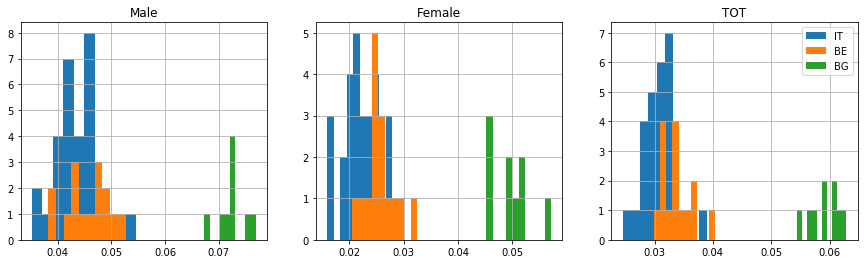

In [23]:
year = 2001
age = 75
sexes = {-1: "TOT", 1: "Female", 0: "Male"}
countries = ["IT", "BE", "BG"]

nSexes = len(sexes)
plt.figure(figsize=(5*nSexes,4))
for i, sex in enumerate(sexes):
    plt.subplot(1,nSexes,1+i)
    plt.title(sexes[sex])
    for country in countries:
        death_df[year, sex, age][death_df.index.str.startswith(country)].hist(label=country)
plt.legend()

In [24]:
# Save table for later use...
death_df.to_pickle("resources/Europe/population/demography/deathRates_1990-2015_sexAge_nuts2_PANDAS.pkl")